# Preprocessing

Now that our images have now been split into training, testing, and validation sets, we can use Keras's ImageDataGenerator to preprocess our images and feed them through our model. 

In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve, f1_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

We initiate the Image Data Generator and implement a variety of changes to the images to make our model more robust.

In [3]:
datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


In [4]:
# load and iterate training dataset.
#Our target size is 50x50 which is our image size, each batch size is 130 and we shuffle them to our model doesn't fall into a pattern. 
train_gen = datagen.flow_from_directory('data/split/train/', target_size=(50,50), color_mode='rgb', batch_size=130, class_mode='binary', shuffle=True)

Found 194266 images belonging to 2 classes.


In [5]:
# load and iterate validation dataset
val_gen = datagen.flow_from_directory('data/split/val/', target_size=(50,50), color_mode='rgb', batch_size=130, class_mode='binary', shuffle=True)


Found 41627 images belonging to 2 classes.


In [6]:
# load and iterate test dataset. Note that we don't shuffle these since these are only for testing and we don't want our labels to get mixed up.
test_gen = datagen.flow_from_directory('data/split/test/', target_size=(50,50), color_mode='rgb', batch_size=1, class_mode='binary', shuffle=False)

Found 41631 images belonging to 2 classes.


# Building the Model

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(50, 50, 3,), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We fit and validate our model over 35 epochs. I started with 10 epochs and slowly increased the number to see if I could get to 90% accuracy. No such luck.

In [25]:

model.fit_generator(train_gen, steps_per_epoch=1500, validation_data=val_gen, validation_steps=321, epochs=35)

Epoch 1/35
1500/1500 [==============================] - 213s 142ms/step - loss: 0.3983 - acc: 0.8257 - val_loss: 0.3719 - val_acc: 0.8420
Epoch 2/35
1500/1500 [==============================] - 210s 140ms/step - loss: 0.3596 - acc: 0.8465 - val_loss: 0.3371 - val_acc: 0.8584
Epoch 3/35
1500/1500 [==============================] - 210s 140ms/step - loss: 0.3463 - acc: 0.8528 - val_loss: 0.3556 - val_acc: 0.8538
Epoch 4/35
1500/1500 [==============================] - 211s 141ms/step - loss: 0.3416 - acc: 0.8543 - val_loss: 0.3537 - val_acc: 0.8517
Epoch 5/35
1500/1500 [==============================] - 210s 140ms/step - loss: 0.3356 - acc: 0.8568 - val_loss: 0.3309 - val_acc: 0.8620
Epoch 6/35
1500/1500 [==============================] - 210s 140ms/step - loss: 0.3301 - acc: 0.8597 - val_loss: 0.3744 - val_acc: 0.8353
Epoch 7/35
1500/1500 [==============================] - 210s 140ms/step - loss: 0.3234 - acc: 0.8627 - val_loss: 0.3163 - val_acc: 0.8666
Epoch 8/35
1500/1500 [============

In [26]:
#save our model for later as fitting takes quite a while. 
model.save('model/breastcancer')

In [7]:
#load our saved model back into the kernel. 
model = tf.keras.models.load_model('model/breastcancer')

# Evaluating the Model 

Evaluating the model on our test set. 

In [8]:
testing = model.evaluate(test_gen)

  ...
    to  
  ['...']
41631/41631 [==============================] - 111s 3ms/step - loss: 0.2932 - accuracy: 0.8785


We hit nearly 88% accuracy which I am very happy with for my first deep learning project. 

Now comes the tricky part. Where do we put our threshold for our classifier to decide if an image is cancerous or not cancerous? Keep in mind that a False Negative predicting the patient doesn't have cancer when they do can potentially be a death sentence so we will consider those more important than your average classification problem would. 

The model's predictions are floats between 0 and 1. We will try out different thresholds between 0 and 1 and see what gives us the best results. 

In [12]:
#the model's predictions
y_pred = model.predict(test_gen)

#Converting the predictions based on different thresholds of .3, .4, .5, .6.
y_pred3 = np.where(y_pred > 0.3, 1, 0)
y_pred4 = np.where(y_pred > 0.4, 1, 0)
y_pred5 = np.where(y_pred > 0.5, 1, 0)
y_pred6 = np.where(y_pred > 0.6, 1, 0)

#Creating confusion matrices for each one to see how the predictions go. 
cm3 = confusion_matrix(test_gen.classes, y_pred3)
cm4 = confusion_matrix(test_gen.classes, y_pred4)
cm5 = confusion_matrix(test_gen.classes, y_pred5)
cm6 = confusion_matrix(test_gen.classes, y_pred6)

Now let's visualize the confusion matrices. 

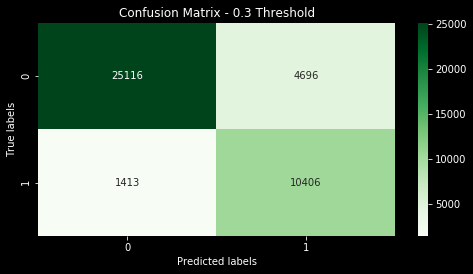

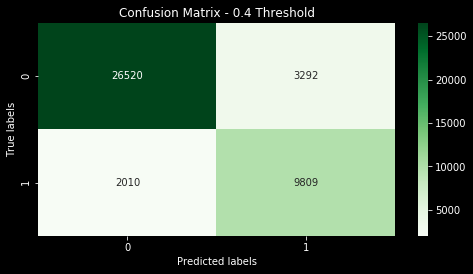

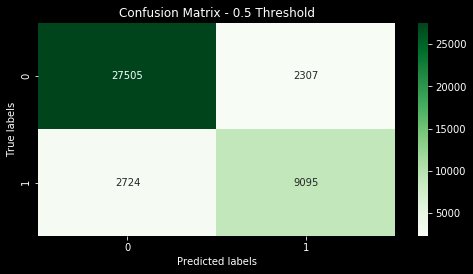

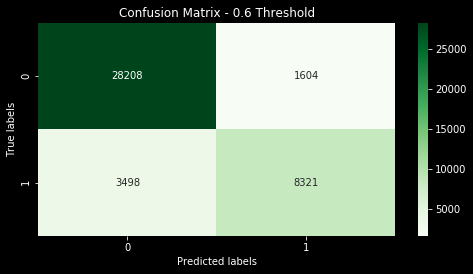

In [14]:
plt.rcParams["figure.figsize"] = (8,18)

ax= plt.subplot(4,1,1)
sns.heatmap(cm3, annot=True, ax = ax, fmt='g', cmap='Greens'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - 0.3 Threshold'); 
plt.show()

ax= plt.subplot(4,1,2)
sns.heatmap(cm4, annot=True, ax = ax, fmt='g', cmap='Greens'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - 0.4 Threshold'); 
plt.show()


ax= plt.subplot(4,1,3)
sns.heatmap(cm5, annot=True, ax = ax, fmt='g', cmap='Greens'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - 0.5 Threshold'); 
plt.show()

ax= plt.subplot(4,1,4)
sns.heatmap(cm6, annot=True, ax = ax, fmt='g', cmap='Greens'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - 0.6 Threshold'); 
plt.show()

The bottom left corner are the examples where the model predicted no cancer where cancer was present. We want to minimize these but at the same time, we can't make them our entire focus or the model will have too many false positives to be useful. 

Let's look at the ROC AUC scores for these predictors as well. 

In [36]:
roc_auc3 = roc_auc_score(test_gen.classes, y_pred3)
roc_auc4 = roc_auc_score(test_gen.classes, y_pred4)
roc_auc5 = roc_auc_score(test_gen.classes, y_pred5)
roc_auc6 = roc_auc_score(test_gen.classes, y_pred6)


print(roc_auc3, roc_auc4, roc_auc5, roc_auc6)

0.8614631383718145 0.8597547592915719 0.8460693513516698 0.8251160185292707


Finally let's look at the weighted average of their F1 scores. 

In [39]:
f1_pred3 = f1_score(y_pred3, test_gen.classes, average='weighted')
f1_pred4 = f1_score(y_pred4, test_gen.classes, average='weighted')
f1_pred5 = f1_score(y_pred5, test_gen.classes, average='weighted')
f1_pred6 = f1_score(y_pred6, test_gen.classes, average='weighted')

print(f'The weighted F1 score for .3 threshold was {f1_pred3}')
print(f'The weighted F1 score for .4 threshold was {f1_pred4}')
print(f'The weighted F1 score for .5 threshold was {f1_pred5}')
print(f'The weighted F1 score for .6 threshold was {f1_pred6}')

The weighted F1 score for .3 threshold was 0.848586192694454
The weighted F1 score for .4 threshold was 0.8707663293217979
The weighted F1 score for .5 threshold was 0.8798179786201038
The weighted F1 score for .6 threshold was 0.880897985479939


# Analysis

.3 gives us the lowest amount of False Negatives but it gives us tons of False positives and has by far the lowest F1 score. .6 on the other hand gives us by far the most False Negatives but only gives a slight improvement in F1 score over .5. It's going to be between .4 and .5.

Let's look at their full classification reports. 

In [50]:
print('------------- Classification Report for .4 -------------')
print(classification_report(test_gen.classes, y_pred4))


------------- Classification Report for .4 -------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     29812
           1       0.75      0.83      0.79     11819

    accuracy                           0.87     41631
   macro avg       0.84      0.86      0.85     41631
weighted avg       0.88      0.87      0.87     41631



In [51]:
print('-------------- Classification Report for .5 -------------')
print(classification_report(test_gen.classes, y_pred5))

-------------- Classification Report for .5 -------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     29812
           1       0.80      0.77      0.78     11819

    accuracy                           0.88     41631
   macro avg       0.85      0.85      0.85     41631
weighted avg       0.88      0.88      0.88     41631



.5 has the slightly heigher weighted f1 score and it has better the precision for our target by .05. In my estimation though, Recall is the more important metric here because it's finding more instances overall of cancer. This will lead to more false positives but I believe it's worth finding more instances of cancer in the long run. A false diagnosis of cancer will scare the patient until the truth comes out, but a missed diagnosis of cancer could possibly lead to death. 

.4 should be our classification threshold for cancer. 

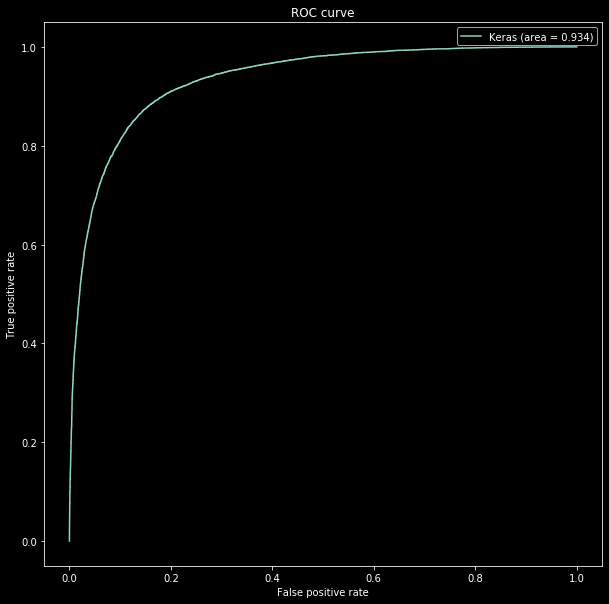

In [14]:
plt.rcParams["figure.figsize"] = (10,10)
fpr, tpr, thresholds = roc_curve(test_gen.classes, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.title('ROC curve')
plt.show()

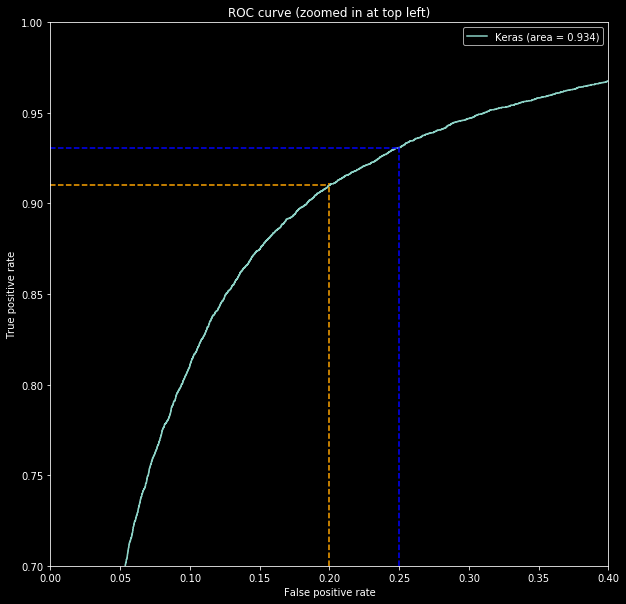

In [42]:
plt.xlim(0, 0.4)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(roc_auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

plt.axvline(x=.2, color='orange', ls='--',ymax=.705)
plt.axhline(y=.91, color='orange', ls='--', xmax=.5)
plt.axvline(x=.25, color='blue', ls='--', ymax=.77)
plt.axhline(y=.9305, color='blue', ls='--', xmax=.625 )
plt.show()

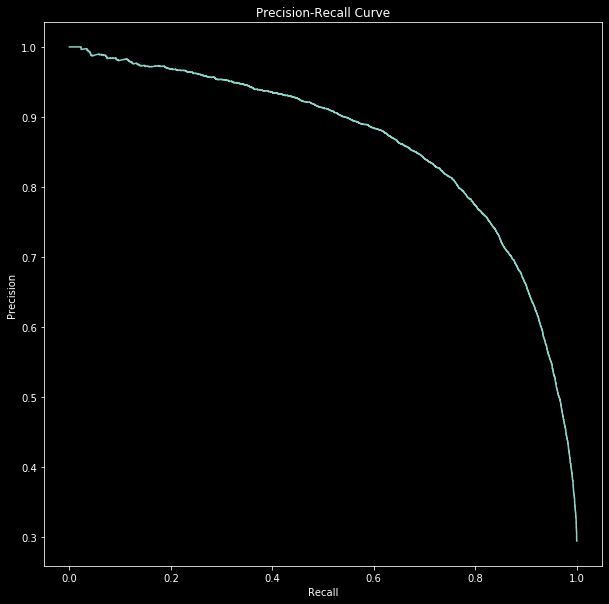

In [40]:
precision, recall, thresholds = precision_recall_curve(test_gen.classes, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Takeaways and Future Study

-F1 score and Accuracy aren't not necessarily the most important metrics depending on what is being prioritized in a given problem. 
<p>-A deep learning model does not need to be super complex to give good results.</p> 
-In the future, I'd like to make a more complex model and see how I can improve the results. I would also be curious to see how the model would perform on other data if I could get my hands on it. 
